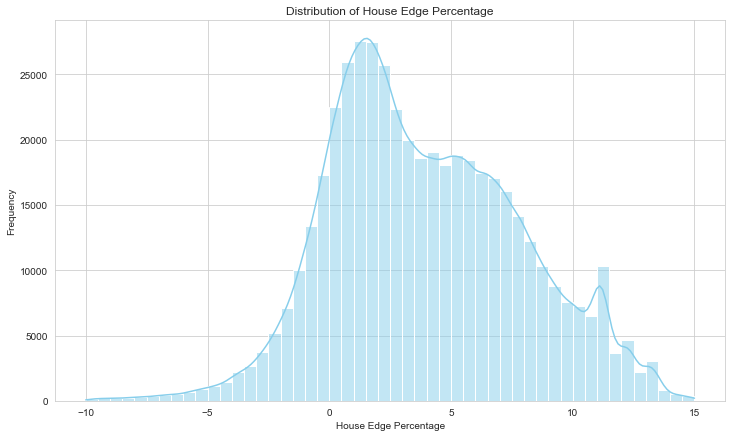

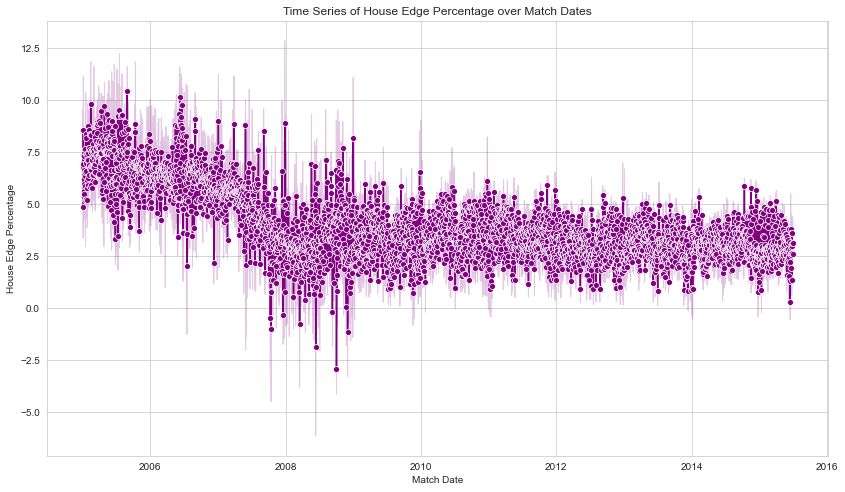

In [6]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# This line allows visualizations to be rendered directly within the Jupyter notebook.
%matplotlib inline

# Set a consistent plotting style.
sns.set_style("whitegrid")

# Adjust pandas settings to display all columns and rows.
pd.set_option("display.max_columns", None, 'display.max_rows', None)

# Read the dataset into a pandas DataFrame.
df = pd.read_csv('closing_odds.csv')

# Convert 'match_date' to datetime type for time series operations.
df['match_date'] = pd.to_datetime(df['match_date'])

# Clean the dataset: Remove null values, sort by date and reset index.
df.dropna(inplace=True)
df.sort_values(by='match_date', ascending=False, inplace=True)
df.reset_index(drop=True, inplace=True)

# Create a new column combining home and away team names for identification.
df['homevsaway'] = df['home_team'] + '-' + df['away_team']

# Calculate the 'edge' using max odds and create a new column.
df['lcm_value'] = df['max_odds_home_win'] * df['max_odds_draw'] * df['max_odds_away_win']
df['edge'] = ((df['lcm_value'] / df['max_odds_home_win']) + 
              (df['lcm_value'] / df['max_odds_draw']) + 
              (df['lcm_value'] / df['max_odds_away_win'])) / df['lcm_value']
df['edgepercent%'] = (df['edge'] - 1) * 100

# Extract year from 'match_date' for yearly trend analysis.
df['year'] = df['match_date'].dt.year

# Filter dataset based on specific edge percentage conditions.
df = df[(df['edgepercent%'] <= 15) & (df['edgepercent%'] >= -10)].copy()

# Save the cleaned dataset for future use.
df.to_csv('processed_closing_odds.csv', index=False)

# Calculate and create a new column for competitiveness using the standard deviation.
df['competitiveness'] = df[['avg_odds_home_win', 'avg_odds_draw', 'avg_odds_away_win']].std(axis=1)

# Visualize distribution of edge percentages.
plt.figure(figsize=(12, 7))
sns.histplot(df['edgepercent%'], bins=50, color='skyblue', kde=True)
plt.title('Distribution of House Edge Percentage')
plt.xlabel('House Edge Percentage')
plt.ylabel('Frequency')
plt.show()

# Time series visualization of edge percentages.
plt.figure(figsize=(14, 8))
sns.lineplot(data=df, x='match_date', y='edgepercent%', color='purple', marker='o')
plt.title('Time Series of House Edge Percentage over Match Dates')
plt.xlabel('Match Date')
plt.ylabel('House Edge Percentage')
plt.show()

# Interactive bar chart comparing profitable vs non-profitable situations.
profitable = df[df['edgepercent%'] < 0].shape[0]
non_profitable = df[df['edgepercent%'] >= 0].shape[0]

data = pd.DataFrame({
    'Situation': ['Profitable', 'Non-Profitable'],
    'Count': [profitable, non_profitable]
})

fig = px.bar(data, x='Situation', y='Count',
             title="Profitable vs Non-Profitable Situations",
             color='Situation', 
             color_discrete_map={"Profitable": "green", "Non-Profitable": "red"},
             text='Count')
fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(title_font_size=24, title_font_family="Arial", title_x=0.5)
fig.show()

# Visualize the top 10 bookies based on max odds provided.
top_bookies_home = df['top_bookie_home_win'].value_counts()
top_bookies_draw = df['top_bookie_draw'].value_counts()
top_bookies_away = df['top_bookie_away_win'].value_counts()

all_bookies = pd.concat([top_bookies_home, top_bookies_draw, top_bookies_away], axis=1).fillna(0)
all_bookies.columns = ['Home Win', 'Draw', 'Away Win']
all_bookies['Total'] = all_bookies.sum(axis=1)
all_bookies = all_bookies.sort_values(by='Total', ascending=False).head(10)

fig = px.bar(all_bookies, y=all_bookies.index, x=['Home Win', 'Draw', 'Away Win'], title="Top 10 Bookies by Number of Max Odds Provided", orientation='h')
fig.update_layout(title_font_size=24, title_font_family="Arial", title_x=0.5)
fig.show()


In [8]:
df.head()

,match_id,league,match_date,home_team,home_score,away_team,away_score,avg_odds_home_win,avg_odds_draw,avg_odds_away_win,max_odds_home_win,max_odds_draw,max_odds_away_win,top_bookie_home_win,top_bookie_draw,top_bookie_away_win,n_odds_home_win,n_odds_draw,n_odds_away_win,homevsaway,lcm_value,edge,edgepercent%,year,competitiveness
0,876812,World: Club Friendly,2015-06-30,Zavrc,0,Istra 1961,0,4.7145,3.9259,1.5650,5.46,4.25,1.70,Pinnacle Sports,888sport,Ladbrokes,22,22,22,Zavrc-Istra 1961,39.44850,1.006680,0.667959,2015,1.638856
1,876780,World: Club Friendly,2015-06-30,Arka Gdynia,2,APOEL,1,5.6133,4.0548,1.4659,6.50,4.60,1.55,myBet,Betway,Pinnacle Sports,27,27,27,Arka Gdynia-APOEL,46.34500,1.016399,1.639875,2015,2.094925
2,876777,World: Club Friendly,2015-06-30,Grasshoppers,1,Biel,1,1.4129,4.5575,5.5936,1.47,5.15,6.50,Pinnacle Sports,Pinnacle Sports,bet365,28,28,28,Grasshoppers-Biel,49.20825,1.028293,2.829302,2015,2.177164
3,876776,World: Club Friendly,2015-06-30,CSKA Moscow,0,F. Voronezh,1,1.2070,5.9400,8.7455,1.23,6.50,12.00,888sport,Betsafe,Ladbrokes,20,20,20,CSKA Moscow-F. Voronezh,95.94000,1.050188,5.018762,2015,3.810098
4,876775,Uzbekistan: Professional Football League,2015-06-30,Shortan Guzor,0,Met. Bekobod,3,1.6000,3.7500,4.3500,1.60,3.75,4.35,888sport,888sport,888sport,1,1,1,Shortan Guzor-Met. Bekobod,26.10000,1.121552,12.155172,2015,1.445971
